# Homework 06: One-Versus-All Support Vector Classification

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.spatial.distance as dt
import cvxopt as cvx
from sklearn.metrics import accuracy_score

%matplotlib inline

## Importing Data Set

In [2]:
images = pd.read_csv("hw06_images.csv", header=None)
labels = pd.read_csv("hw06_labels.csv", header=None)

## Train-Test Split

In [3]:
X_train = images[:1000]
y_train = np.array(labels[:1000][0])
X_test = images[1000:]
y_test = np.array(labels[1000:][0])

In [4]:
N_train = len(y_train)
N_test = len(y_test)

## Distance and Kernel Functions (Gaussian Kernel)
$\begin{equation}
    \begin{split}
        d(\boldsymbol{x}_{i}, \boldsymbol{x}_{j}) &= ||\boldsymbol{x}_{i} - \boldsymbol{x}_{j}||_{2} = \sqrt{(\boldsymbol{x}_{i} - \boldsymbol{x}_{j})^{\top} (\boldsymbol{x}_{i} - \boldsymbol{x}_{j})} = \sqrt{\sum\limits_{d = 1}^{D}(x_{id} - x_{jd})^{2}} \\
        k(\boldsymbol{x}_{i}, \boldsymbol{x}_{j}) &= \exp\left(-\dfrac{||\boldsymbol{x}_{i} -\boldsymbol{x}_{j}||_{2}^{2}}{2s^{2}}\right)
    \end{split}
\end{equation}$

In [5]:
def gaussian_kernel(X1, X2, s):
    D = dt.cdist(X1, X2)
    K = np.exp(-D**2 / (2 * s**2))
    return(K)

## Learning Algorithm

### Train Set

In [6]:
def one_vs_all_classification(C, class_num):
    y_train_ = y_train.copy()
    y_train_[y_train_ != class_num] = -1
    y_train_[y_train_ == class_num] = 1
    s = 10
    K_train = gaussian_kernel(X_train, X_train, s)
    yyK = np.matmul(y_train_[:,None], y_train_[None,:]) * K_train
    
    C = C
    epsilon = 1e-3
    print(f"C = {C}, class = {class_num}")
    
    P = cvx.matrix(yyK)
    q = cvx.matrix(-np.ones((N_train, 1)))
    G = cvx.matrix(np.vstack((-np.eye(N_train), np.eye(N_train))))
    h = cvx.matrix(np.vstack((np.zeros((N_train, 1)), C * np.ones((N_train, 1)))))
    A = cvx.matrix(1.0 * y_train_[None,:])
    b = cvx.matrix(0.0)
    
    result = cvx.solvers.qp(P, q, G, h, A, b)
    alpha = np.reshape(result["x"], N_train)
    alpha[alpha < C * epsilon] = 0
    alpha[alpha > C * (1 - epsilon)] = C
    
    support_indices, = np.where(alpha != 0)
    active_indices, = np.where(np.logical_and(alpha != 0, alpha < C))
    w0 = np.mean(y_train_[active_indices] * (1 - np.matmul(yyK[np.ix_(active_indices, support_indices)], alpha[support_indices])))
    
    f_predicted = np.matmul(K_train, y_train_[:,None] * alpha[:,None]) + w0

    return f_predicted

In [7]:
def predict(C):
    f_predicted_1 = one_vs_all_classification(C=C, class_num=1)
    f_predicted_2 = one_vs_all_classification(C=C, class_num=2)
    f_predicted_3 = one_vs_all_classification(C=C, class_num=3)
    f_predicted_4 = one_vs_all_classification(C=C, class_num=4)
    f_predicted_5 = one_vs_all_classification(C=C, class_num=5)
    
    y_predicted = []
        
    for i in range(1000):
        predictions = [f_predicted_1[i], f_predicted_2[i], f_predicted_3[i], f_predicted_4[i], f_predicted_5[i]]
        max_value = max(predictions)
        max_index = predictions.index(max_value)
        y_predicted.append(max_index + 1)

    return y_predicted

In [8]:
y_predicted = predict(C=10)

C = 10, class = 1
     pcost       dcost       gap    pres   dres
 0:  2.9600e+01 -4.2260e+04  8e+04  4e-01  3e-14
 1:  1.2992e+01 -7.4611e+03  8e+03  2e-02  3e-14
 2: -6.2643e+02 -2.9089e+03  2e+03  4e-03  2e-14
 3: -8.9105e+02 -1.7204e+03  8e+02  1e-03  2e-14
 4: -1.0255e+03 -1.3482e+03  3e+02  2e-04  3e-14
 5: -1.0893e+03 -1.1778e+03  9e+01  2e-05  3e-14
 6: -1.1096e+03 -1.1353e+03  3e+01  3e-07  3e-14
 7: -1.1169e+03 -1.1209e+03  4e+00  5e-14  3e-14
 8: -1.1184e+03 -1.1185e+03  1e-01  8e-14  3e-14
 9: -1.1185e+03 -1.1185e+03  4e-03  6e-15  3e-14
10: -1.1185e+03 -1.1185e+03  7e-05  6e-14  3e-14
Optimal solution found.
C = 10, class = 2
     pcost       dcost       gap    pres   dres
 0:  1.9161e+02 -4.0951e+04  8e+04  4e-01  3e-14
 1:  1.7375e+02 -7.6611e+03  9e+03  2e-02  3e-14
 2: -4.0615e+02 -2.9616e+03  3e+03  6e-03  3e-14
 3: -6.2557e+02 -1.7531e+03  1e+03  2e-03  3e-14
 4: -7.5417e+02 -1.1618e+03  4e+02  4e-04  3e-14
 5: -8.2696e+02 -9.7495e+02  1e+02  9e-14  4e-14
 6: -8.5262

In [9]:
confusion_matrix = pd.crosstab(np.reshape(y_predicted, N_train), y_train, rownames = ['y_predicted'], colnames = ['y_train'])
print(confusion_matrix)

y_train        1    2    3    4    5
y_predicted                         
1            207    1    0    9    0
2              2  199    1    1    0
3              0    1  204    6    0
4              0    1    4  185    1
5              0    0    0    0  178


In [10]:
train_predictions = []
for C in [0.1, 1, 10, 100, 1000]:
    train_predictions.append(predict(C))

C = 0.1, class = 1
     pcost       dcost       gap    pres   dres
 0: -1.3936e+02 -2.2047e+02  7e+03  3e+01  3e-15
 1: -3.4801e+01 -2.0264e+02  4e+02  9e-01  3e-15
 2: -2.8151e+01 -7.9601e+01  5e+01  4e-16  9e-16
 3: -3.1266e+01 -4.3423e+01  1e+01  2e-16  8e-16
 4: -3.2572e+01 -3.9120e+01  7e+00  3e-16  6e-16
 5: -3.3423e+01 -3.6637e+01  3e+00  9e-16  6e-16
 6: -3.3666e+01 -3.6029e+01  2e+00  4e-16  6e-16
 7: -3.4121e+01 -3.4971e+01  9e-01  9e-16  7e-16
 8: -3.4319e+01 -3.4585e+01  3e-01  4e-16  8e-16
 9: -3.4415e+01 -3.4445e+01  3e-02  2e-16  8e-16
10: -3.4429e+01 -3.4430e+01  1e-03  3e-16  8e-16
11: -3.4429e+01 -3.4429e+01  5e-05  2e-16  8e-16
12: -3.4429e+01 -3.4429e+01  1e-06  5e-16  8e-16
Optimal solution found.
C = 0.1, class = 2
     pcost       dcost       gap    pres   dres
 0: -1.1812e+02 -2.1835e+02  7e+03  3e+01  3e-15
 1: -3.1287e+01 -2.0015e+02  5e+02  1e+00  3e-15
 2: -2.4529e+01 -8.1514e+01  6e+01  4e-16  1e-15
 3: -2.7550e+01 -4.0807e+01  1e+01  1e-15  9e-16
 4: -2.87

 3: -7.4758e+02 -1.9976e+03  1e+03  9e-04  3e-14
 4: -8.9381e+02 -1.4365e+03  5e+02  3e-04  3e-14
 5: -9.8213e+02 -1.1677e+03  2e+02  5e-05  4e-14
 6: -1.0174e+03 -1.0749e+03  6e+01  1e-05  4e-14
 7: -1.0296e+03 -1.0480e+03  2e+01  1e-15  4e-14
 8: -1.0350e+03 -1.0380e+03  3e+00  8e-14  4e-14
 9: -1.0360e+03 -1.0362e+03  2e-01  9e-14  5e-14
10: -1.0361e+03 -1.0361e+03  4e-03  6e-14  5e-14
11: -1.0361e+03 -1.0361e+03  7e-05  9e-14  5e-14
Optimal solution found.
C = 10, class = 4
     pcost       dcost       gap    pres   dres
 0: -5.0057e+02 -5.0242e+04  8e+04  3e-01  4e-14
 1: -5.5603e+02 -8.9813e+03  9e+03  1e-02  4e-14
 2: -1.3487e+03 -3.4368e+03  2e+03  2e-03  4e-14
 3: -1.6731e+03 -2.5433e+03  9e+02  3e-04  5e-14
 4: -1.8026e+03 -2.1922e+03  4e+02  6e-05  5e-14
 5: -1.8680e+03 -1.9850e+03  1e+02  8e-06  5e-14
 6: -1.8927e+03 -1.9224e+03  3e+01  7e-07  6e-14
 7: -1.9008e+03 -1.9050e+03  4e+00  1e-13  6e-14
 8: -1.9023e+03 -1.9024e+03  1e-01  5e-14  6e-14
 9: -1.9023e+03 -1.9023e+03 

 8: -6.2603e+02 -3.2740e+03  3e+03  2e-13  1e-13
 9: -1.2572e+03 -2.2316e+03  1e+03  2e-13  1e-13
10: -1.4851e+03 -1.8322e+03  3e+02  3e-13  9e-14
11: -1.5793e+03 -1.6883e+03  1e+02  5e-14  1e-13
12: -1.6114e+03 -1.6383e+03  3e+01  1e-13  1e-13
13: -1.6180e+03 -1.6250e+03  7e+00  8e-14  1e-13
14: -1.6203e+03 -1.6207e+03  4e-01  1e-13  1e-13
15: -1.6204e+03 -1.6204e+03  5e-03  3e-13  1e-13
16: -1.6204e+03 -1.6204e+03  9e-05  2e-13  1e-13
Optimal solution found.
C = 1000, class = 4
     pcost       dcost       gap    pres   dres
 0:  1.6092e+07 -3.6559e+08  5e+08  2e-01  4e-12
 1:  1.1537e+07 -6.1870e+07  8e+07  2e-02  4e-12
 2:  4.8978e+06 -1.8971e+07  2e+07  6e-03  3e-12
 3:  1.7138e+06 -6.8321e+06  9e+06  7e-04  3e-12
 4:  5.3680e+05 -2.3698e+06  3e+06  3e-12  2e-12
 5:  2.3023e+05 -1.0554e+06  1e+06  7e-12  1e-12
 6:  9.0450e+04 -4.3818e+05  5e+05  2e-12  1e-12
 7:  1.1082e+04 -3.9758e+04  5e+04  5e-13  6e-13
 8: -9.7930e+02 -8.9481e+03  8e+03  1e-12  3e-13
 9: -2.5200e+03 -5.3745e+0

In [11]:
train_accuracies = []

for prediction in train_predictions:
    train_accuracies.append(accuracy_score(y_train, prediction)),

### Test Set

In [12]:
def one_vs_all_classification(C, class_num):
    y_test_ = y_test.copy()
    y_test_[y_test_ != class_num] = -1
    y_test_[y_test_ == class_num] = 1
    s = 10
    K_test = gaussian_kernel(X_test, X_test, s)
    yyK = np.matmul(y_test_[:,None], y_test_[None,:]) * K_test
    
    C = C
    epsilon = 1e-3
    print(f"C = {C}, class = {class_num}")
    
    P = cvx.matrix(yyK)
    q = cvx.matrix(-np.ones((N_test, 1)))
    G = cvx.matrix(np.vstack((-np.eye(N_test), np.eye(N_test))))
    h = cvx.matrix(np.vstack((np.zeros((N_test, 1)), C * np.ones((N_test, 1)))))
    A = cvx.matrix(1.0 * y_test_[None,:])
    b = cvx.matrix(0.0)
    
    result = cvx.solvers.qp(P, q, G, h, A, b)
    alpha = np.reshape(result["x"], N_test)
    alpha[alpha < C * epsilon] = 0
    alpha[alpha > C * (1 - epsilon)] = C
    
    support_indices, = np.where(alpha != 0)
    active_indices, = np.where(np.logical_and(alpha != 0, alpha < C))
    w0 = np.mean(y_test_[active_indices] * (1 - np.matmul(yyK[np.ix_(active_indices, support_indices)], alpha[support_indices])))
    
    f_predicted = np.matmul(K_test, y_test_[:,None] * alpha[:,None]) + w0

    return f_predicted

In [13]:
def predict(C):
    f_predicted_1 = one_vs_all_classification(C=C, class_num=1)
    f_predicted_2 = one_vs_all_classification(C=C, class_num=2)
    f_predicted_3 = one_vs_all_classification(C=C, class_num=3)
    f_predicted_4 = one_vs_all_classification(C=C, class_num=4)
    f_predicted_5 = one_vs_all_classification(C=C, class_num=5)
    
    y_predicted = []
        
    for i in range(4000):
        predictions = [f_predicted_1[i], f_predicted_2[i], f_predicted_3[i], f_predicted_4[i], f_predicted_5[i]]
        max_value = max(predictions)
        max_index = predictions.index(max_value)
        y_predicted.append(max_index + 1)

    return y_predicted

In [14]:
y_predicted = predict(C=10)

C = 10, class = 1
     pcost       dcost       gap    pres   dres
 0: -1.7686e+03 -1.7643e+05  4e+05  4e-01  9e-14
 1: -1.4025e+03 -4.1866e+04  5e+04  4e-02  9e-14
 2: -2.5490e+03 -1.6081e+04  2e+04  1e-02  8e-14
 3: -3.2976e+03 -1.0360e+04  8e+03  4e-03  8e-14
 4: -3.7903e+03 -7.9033e+03  4e+03  2e-03  8e-14
 5: -4.1528e+03 -6.3205e+03  2e+03  5e-04  8e-14
 6: -4.4307e+03 -5.2802e+03  9e+02  1e-04  9e-14
 7: -4.5567e+03 -4.9042e+03  3e+02  2e-05  1e-13
 8: -4.6223e+03 -4.7484e+03  1e+02  2e-13  1e-13
 9: -4.6510e+03 -4.6937e+03  4e+01  3e-13  1e-13
10: -4.6643e+03 -4.6728e+03  9e+00  4e-14  1e-13
11: -4.6677e+03 -4.6683e+03  7e-01  2e-13  1e-13
12: -4.6680e+03 -4.6680e+03  1e-02  2e-14  1e-13
13: -4.6680e+03 -4.6680e+03  2e-04  9e-14  1e-13
Optimal solution found.
C = 10, class = 2
     pcost       dcost       gap    pres   dres
 0: -6.1183e+02 -1.8545e+05  4e+05  5e-01  1e-13
 1:  2.5311e+02 -4.2081e+04  6e+04  4e-02  1e-13
 2: -1.0791e+03 -1.4921e+04  2e+04  1e-02  1e-13
 3: -1.8316

In [15]:
confusion_matrix = pd.crosstab(np.reshape(y_predicted, N_test), y_test, rownames = ['y_predicted'], colnames = ['y_train'])
print(confusion_matrix)

y_train        1    2    3    4    5
y_predicted                         
1            769    5    0   59    0
2             10  787    9   12    1
3              0   10  734   23    0
4             21    7   28  729    0
5              0    1    0    0  795


In [16]:
test_predictions = []
for C in [0.1, 1, 10, 100, 1000]:
    test_predictions.append(predict(C))

C = 0.1, class = 1
     pcost       dcost       gap    pres   dres
 0: -4.9440e+02 -8.9679e+02  3e+04  3e+01  9e-15
 1: -1.0377e+02 -8.2565e+02  2e+03  1e+00  8e-15
 2: -7.7593e+01 -3.3851e+02  3e+02  6e-02  3e-15
 3: -8.6377e+01 -1.4659e+02  6e+01  1e-02  2e-15
 4: -9.3179e+01 -1.1953e+02  3e+01  4e-03  2e-15
 5: -9.5826e+01 -1.1143e+02  2e+01  2e-03  2e-15
 6: -9.7580e+01 -1.0668e+02  9e+00  1e-03  2e-15
 7: -9.8429e+01 -1.0457e+02  6e+00  6e-04  2e-15
 8: -9.9471e+01 -1.0226e+02  3e+00  2e-04  3e-15
 9: -1.0009e+02 -1.0106e+02  1e+00  5e-05  3e-15
10: -1.0035e+02 -1.0058e+02  2e-01  1e-15  3e-15
11: -1.0045e+02 -1.0047e+02  2e-02  1e-15  3e-15
12: -1.0046e+02 -1.0046e+02  2e-03  3e-15  3e-15
13: -1.0046e+02 -1.0046e+02  5e-05  3e-15  3e-15
Optimal solution found.
C = 0.1, class = 2
     pcost       dcost       gap    pres   dres
 0: -3.8581e+02 -8.8351e+02  3e+04  3e+01  9e-15
 1: -8.8085e+01 -8.1232e+02  2e+03  1e+00  1e-14
 2: -6.6335e+01 -3.0088e+02  3e+02  5e-02  3e-15
 3: -7.51

 7: -4.5567e+03 -4.9042e+03  3e+02  2e-05  1e-13
 8: -4.6223e+03 -4.7484e+03  1e+02  2e-13  1e-13
 9: -4.6510e+03 -4.6937e+03  4e+01  3e-13  1e-13
10: -4.6643e+03 -4.6728e+03  9e+00  4e-14  1e-13
11: -4.6677e+03 -4.6683e+03  7e-01  2e-13  1e-13
12: -4.6680e+03 -4.6680e+03  1e-02  2e-14  1e-13
13: -4.6680e+03 -4.6680e+03  2e-04  9e-14  1e-13
Optimal solution found.
C = 10, class = 2
     pcost       dcost       gap    pres   dres
 0: -6.1183e+02 -1.8545e+05  4e+05  5e-01  1e-13
 1:  2.5311e+02 -4.2081e+04  6e+04  4e-02  1e-13
 2: -1.0791e+03 -1.4921e+04  2e+04  1e-02  1e-13
 3: -1.8316e+03 -8.6828e+03  7e+03  4e-03  1e-13
 4: -2.1659e+03 -6.9484e+03  5e+03  2e-03  1e-13
 5: -2.5074e+03 -5.1813e+03  3e+03  1e-03  1e-13
 6: -2.7675e+03 -4.0940e+03  1e+03  2e-04  1e-13
 7: -2.9275e+03 -3.5648e+03  6e+02  7e-05  2e-13
 8: -3.0222e+03 -3.2866e+03  3e+02  2e-13  2e-13
 9: -3.0781e+03 -3.1641e+03  9e+01  2e-13  2e-13
10: -3.0989e+03 -3.1263e+03  3e+01  2e-13  2e-13
11: -3.1080e+03 -3.1135e+03 

C = 1000, class = 1
     pcost       dcost       gap    pres   dres
 0:  2.8735e+07 -1.2426e+09  2e+09  3e-01  8e-12
 1:  2.4830e+07 -2.4489e+08  3e+08  3e-02  8e-12
 2:  1.2663e+07 -7.9470e+07  1e+08  8e-03  7e-12
 3:  6.4037e+06 -3.4669e+07  4e+07  2e-03  5e-12
 4:  2.9802e+06 -1.5391e+07  2e+07  2e-04  5e-12
 5:  1.4088e+06 -7.3164e+06  9e+06  3e-05  4e-12
 6:  7.7310e+05 -4.2550e+06  5e+06  1e-06  3e-12
 7:  5.4367e+05 -2.7357e+06  3e+06  5e-12  3e-12
 8:  1.9567e+05 -9.5152e+05  1e+06  5e-12  2e-12
 9:  6.3415e+04 -3.6443e+05  4e+05  1e-12  2e-12
10:  4.9936e+03 -8.6977e+04  9e+04  3e-12  1e-12
11: -8.1138e+03 -3.4654e+04  3e+04  2e-12  1e-12
12: -1.1544e+04 -2.3308e+04  1e+04  7e-13  9e-13
13: -1.2909e+04 -1.7726e+04  5e+03  2e-12  8e-13
14: -1.3533e+04 -1.5530e+04  2e+03  8e-13  9e-13
15: -1.3781e+04 -1.4763e+04  1e+03  2e-12  1e-12
16: -1.3966e+04 -1.4315e+04  3e+02  1e-12  9e-13
17: -1.4040e+04 -1.4143e+04  1e+02  1e-12  1e-12
18: -1.4075e+04 -1.4081e+04  6e+00  7e-13  9e-13
1

In [17]:
test_accuracies = []

for prediction in test_predictions:
    test_accuracies.append(accuracy_score(y_test, prediction)),

## Visualization

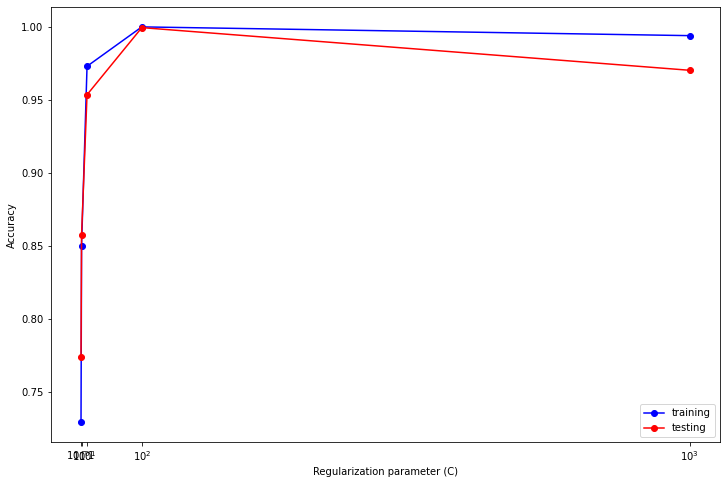

In [18]:
plt.figure(figsize=(12, 8))

plt.plot([0.1, 1, 10, 100, 1000], train_accuracies, color="blue", marker="o", label="training")
plt.plot([0.1, 1, 10, 100, 1000], test_accuracies, color="red", marker="o", label="testing")

plt.ticklabel_format(style='sci', axis='x', scilimits=(10**-1, 10**3))
plt.xticks(ticks=[0.1, 1, 10, 100, 1000], labels=[f"$10^-1$", f"$10^0$", f"$10^1$", f"$10^2$", f"$10^3$"])

plt.xlabel("Regularization parameter (C)")
plt.ylabel("Accuracy")

plt.legend()

plt.xticks()
plt.show()